In [12]:
#!pip install sweetviz
#sweet_report = sv.analyze(df)
#sweet_report.show_html('sweet_report.html')
!pip install pyclustering
!pip install tqdm
!pip install python-dotenv
!pip install seaborn
!pip install beautifulsoup4
!pip install country-named-entity-recognition
!pip install flickrapi
!pip install geopy
!pip install datasketch



Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python3 -m pip install --up

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
#import networkx as nx
#from networkx.algorithms import community
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.cure import cure

from sklearn.metrics.pairwise import cosine_similarity
import time
import psutil
from datasketch import MinHash, MinHashLSH



from multiprocessing import process
from re import M
from typing import Counter
import requests
from bs4 import BeautifulSoup
import os
from country_named_entity_recognition import find_countries
import flickrapi
from geopy.geocoders import Nominatim
import json
from tqdm import tqdm
from collections import Counter
from dotenv import load_dotenv
import math

from sklearn.cluster import SpectralClustering
from sklearn.datasets import make_blobs


In [14]:
##START OF FLICKR PART
def configure():
    load_dotenv()

configure()

# Getting the data

### NomadList data

In [39]:
def get_data(filepath):
    current_path = os.getcwd()
    df = pd.read_csv(current_path+filepath)
    return df


In [40]:
filepath_nomadlist = '/datasets/nomadlist/cities_predict.csv'
df_nomadlist = get_data(filepath_nomadlist)

##IMPORTING SDG DATA
filepath_SDG = "/datasets/SDG_CSV/SDGData.csv"
df_SDG = get_data(filepath_SDG)
df_SDG = df_SDG[['Country Code', 'Country Name', 'Indicator Name', '2015']]
df_SDG = df_SDG.dropna()

### Flickr data

In [69]:
def get_city_name_from_nomadlist(df_nomadlist):
    cities = df_nomadlist['place_slug']
    countries = df_nomadlist['country']
    cities_list = []
    for city, country in zip(cities, countries):
        number_of_country_words = len(country.split(' '))
        city_name = ' '.join(city.split('-')[:-number_of_country_words])
        cities_list.append(city_name)

    cities_list = sorted(cities_list)
    return cities_list

def get_geoloc_per_city(cities_list, saving_filepath):
    current_path = os.getcwd()
    geolocator = Nominatim(user_agent='myapplication')
    cities_coord = {}

    if os.path.exists(current_path+saving_filepath) and os.path.getsize(current_path+saving_filepath) > 0:
        f = open(current_path+saving_filepath)
        cities_coord = json.load(f)
    else:
        for city in tqdm(cities_list):
            location = geolocator.geocode(city)
            lat = location.raw['lat']
            lon = location.raw['lon']
            cities_coord[city] = (lat, lon)

        with open('cities_coord.json', 'w') as fp:
            json.dump(cities_coord, fp)
    return cities_coord

In [70]:
def get_flickr_data(cities_coord, saving_filepath):
    current_path = os.getcwd()
    flickr = flickrapi.FlickrAPI(os.getenv('api_key'), os.getenv('api_secret'), format='parsed-json')


    extras = ['description','tags','url_sq', 'url_t', 'url_s', 'url_q', 'url_m', 'url_n', 'url_z', 'url_c', 'url_l', 'url_o']
    users = {}
    if os.path.exists(current_path+saving_filepath) and os.path.getsize(current_path+saving_filepath) > 0:
        f = open(current_path+saving_filepath)
        users = json.load(f)
    else:
        for city, coords in tqdm(cities_coord.items()): 
            try:
                images = flickr.photos.search(text='travel', lat = coords[0], lon = coords[1], radius = '30', radius_units = 'km', extras=extras)
                for image in images['photos']['photo']:
                    user = image['owner']
                    if user in users.keys():
                        users[user].append(city)
                    else:
                        users[user] = [city]
            except:
                print(f'Images for {city} not found or another error encountered')

            with open(saving_filepath, 'w') as fp:
                json.dump(users, fp)
    return users

In [71]:
cities_list = get_city_name_from_nomadlist(df_nomadlist)

#Flickr part
saving_filepath = '/datasets/flickr/cities_coord.json'
cities_coord = get_geoloc_per_city(cities_list, saving_filepath)
saving_filepath = '/datasets/flickr/users.json'
users_raw = get_flickr_data(cities_coord, saving_filepath)

# Process data

In [72]:
def merge_data_by_country(df_nomadlist, df_SDG):
    filtered_country_df_nomadlist = df_nomadlist['country'].unique()
    country_codes = {find_countries(country)[0][0].alpha_3: country for country in filtered_country_df_nomadlist if find_countries(country)}

    #Skim the SDG dataset
    for code in country_codes.keys():
        df_SDG.loc[df_SDG['Country Code'] == code, 'Country Name'] = country_codes[code]

    df_SDG = df_SDG.loc[df_SDG['Country Name'].isin(filtered_country_df_nomadlist)]
    number_of_countries = len(df_SDG['Country Code'].unique())

    #Finding columns that preserve all data, i.e. that are shared by every city
    df_SDG_count = df_SDG.groupby(['Indicator Name']).count()
    common_indicators = df_SDG_count[df_SDG_count['2015'] == number_of_countries].reset_index()['Indicator Name']
    df_SDG = df_SDG.loc[df_SDG['Indicator Name'].isin(common_indicators)]


    #Actually merge the data
    df_SDG = df_SDG[['Country Name', 'Indicator Name', '2015']]
    df_SDG = df_SDG.pivot(index = 'Country Name', columns = 'Indicator Name', values = '2015')

    df_SDG = df_SDG.reset_index()
    df_SDG_cleaned = df_SDG.rename(columns={'Country Name': 'country'})

    df_nomadlist = df_nomadlist.merge(df_SDG_cleaned, how='outer', on='country')
    return df_nomadlist

In [73]:
df_nomadlist = merge_data_by_country(df_nomadlist, df_SDG)

In [83]:
def process_data(raw_users):
    users_cities_rating = {}
    number_of_values = 0
    users = {}
    for key, value in raw_users.items():
        uniques = set(value)
        avg_pics_per_place = len(value)/len(uniques)
        city_count = Counter(value)
        maximum_city = max(city_count, key=city_count.get)
        maximum_pics_per_user = city_count[maximum_city]
        #Normalization
        #We want a rating from 0 to 5
        for item, count in city_count.items():
            city_count[item] = math.ceil(city_count[item]/(maximum_pics_per_user/5))
            #city_count[item] /= avg_pics_per_place
            if city_count[item] < 0 or city_count[item] > 5:
                print('ODD')
            else:
                print(city_count[item])

        users_cities_rating[key] = city_count

        users[key] = uniques
        number_of_values += len(users[key])

    return users, users_cities_rating

In [84]:
users, users_cities_rating = process_data(users_raw)

1
1
2
1
5
1
1
5
5
3
3
3
2
1
3
5
1
1
4
1
5
1
1
1
2
3
3
1
1
5
1
2
3
5
2
1
2
1
1
2
3
1
1
1
5
3
2
2
3
1
1
3
2
1
2
2
1
3
2
1
1
2
3
1
2
3
1
1
1
4
5
3
5
3
4
1
1
1
1
1
1
1
1
1
3
1
1
3
1
2
3
1
5
2
3
2
1
2
1
3
4
1
4
1
2
2
2
2
3
1
1
4
5
2
2
3
2
1
4
4
1
2
1
2
2
2
2
5
5
5
1
3
1
4
2
4
5
5
5
2
5
3
3
5
3
3
3
5
5
3
3
3
5
1
3
5
4
2
2
2
1
1
1
1
1
2
1
2
1
1
1
1
2
5
5
5
5
2
2
2
1
2
3
2
3
3
3
4
1
1
3
5
5
5
5
1
3
2
2
3
1
1
2
1
2
3
1
1
1
1
1
2
5
2
2
2
1
1
2
1
1
1
1
2
2
3
1
2
1
2
4
2
3
5
2
2
1
3
1
5
1
1
2
3
1
2
3
2
1
2
1
2
5
1
1
1
1
1
2
1
1
1
1
1
2
2
3
1
2
3
5
5
2
1
1
1
2
1
1
3
1
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
3
1
2
3
1
1
1
1
1
1
5
1
1
1
1
1
5
2
5
2
5
1
1
3
2
2
5
5
5
5
5
4
1
1
1
1
3
2
2
1
3
4
4
5
5
1
4
4
2
5
1
1
1
3
1
5
5
3
5
5
1
5
5
3
2
2
2
2
2
2
2
5
5
3
5
1
1
1
1
1
1
1
3
2
5
1
1
2
1
3
1
1
1
1
1
3
2
1
2
1
1
1
1
1
1
1
5
5
5
5
1
5
5
2
5
1
1
5
3
5
5
5
5
5
5
1
3
1
5
1
5
5
5
5
5
1
5
3
5
5
5
5
5
5
3
5
5
5
5
5
3
5
5
5
5
5
3
3
5
5
5
5
5
5
5
5
5
5
5
5
5
2
5
5
2
5
1
3
1
2
1
1
5
1
5
1
2
1
2


## EDA

In [45]:
df = df_nomadlist
df.isnull().sum()

df.duplicated().sum()
df.head()

1br_studio_rent_in_center  adult_nightlife  air_quality_(year-round)  \
0                      492.0              4.0                      42.0   
1                      223.0              3.0                      19.0   
2                      367.0              2.0                      54.0   
3                      369.0              2.0                      53.0   
4                      216.0              4.0                      41.0   

   airbnb_(monthly)  cashless_society  coca-cola  coffee  cost_of_living  \
0             946.0               1.0       0.70    1.40             3.0   
1             976.0               1.0       0.63    1.11             3.0   
2            2074.0               1.0       0.66    1.94             3.0   
3            1617.0               1.0       0.61    1.23             3.0   
4             641.0               1.0       0.67    1.54             3.0   

   cost_of_living_for_expat  cost_of_living_for_local  ...  startup_score  \
0                     961.0                     626.0  ...            3.0   
1                     697.0                     349.0  ...            3.0   
2                    1072.0                     512.0  ...            3.0   
3                     938.0                     483.0  ...            3.0   
4                     627.0                     380.0  ...            3.0   

   traffic_safety  walkability  nomad_score         region  country  \
0             4.0          4.0         4.03  Latin America   Mexico   
1             4.0          4.0         4.51  Latin America   Mexico   
2             4.0          1.0         3.54  Latin America   Mexico   
3             4.0          4.0         4.17  Latin America   Mexico   
4             4.0          4.0         4.20  Latin America   Mexico   

                place_slug  Access to electricity (% of population)  \
0       mexico-city-mexico                                     99.0   
1            cancun-mexico                                     99.0   
2             tulum-mexico                                     99.0   
3  playa-del-carmen-mexico                                     99.0   
4       guadalajara-mexico                                     99.0   

   Access to electricity, urban (% of urban population)  \
0                                          99.300003      
1                                          99.300003      
2                                          99.300003      
3                                          99.300003      
4                                          99.300003      

   Renewable electricity output (% of total electricity output)  
0                                          15.394134             
1                                          15.394134             
2                                          15.394134             
3                                          15.394134             
4                                          15.394134             

[5 rows x 35 columns]

In [46]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(25, 25))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

ValueError: could not convert string to float: 'Latin America'

# Methodologies

### Clustering

In [ ]:
def plot3dClusterRepresentation(df, num_cols = 4, hasClusterColumn = True):
  # Create a grid of subplots with 4 plots per line
  num_rows = int(np.ceil(len(range(0, 360, 30)) / num_cols))
  fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 3 * num_rows), subplot_kw={'projection': '3d'})

  # Iterate over different angles
  for i, angle in enumerate(range(0, 360, 30)):
      row_index = i // num_cols
      col_index = i % num_cols

      if hasClusterColumn:
        # Scatter plot points by cluster
        for cluster in range(num_clusters):
          cluster_data = df[df['Cluster'] == cluster]
          axes[row_index, col_index].scatter(cluster_data['PCA1'], cluster_data['PCA2'], cluster_data['PCA3'], label=f'Cluster {cluster + 1}')
      else:
        axes[row_index, col_index].scatter(df['PCA1'], df['PCA2'], df['PCA3'])

      axes[row_index, col_index].set_xlabel('PCA1')
      axes[row_index, col_index].set_ylabel('PCA2')
      axes[row_index, col_index].set_zlabel('PCA3')
      axes[row_index, col_index].set_title(f'3D Scatter Plot of Clusters (Angle: {angle}°')

      # Set the viewing angle
      axes[row_index, col_index].view_init(30, angle)

      # Show the legend in the first plot of each row
      if col_index == 0:
          axes[row_index, col_index].legend()

  # Adjust layout to prevent overlapping
  plt.tight_layout()

  return plt.show()

In [ ]:
## remove cost of living both columns
columns_to_drop = ['coca-cola','adult_nightlife','coffee','region', 'place_slug','country','cost_of_living_for_expat','1br_studio_rent_in_center','airbnb_(monthly)']
df_for_clustering = df.drop(columns=columns_to_drop)
df_for_clustering['cost_of_living_for_local'] = - df_for_clustering['cost_of_living_for_local']
df_for_clustering.head()

In [ ]:
scaler = MinMaxScaler((1,5))
normalized_features = scaler.fit_transform(df_for_clustering)

# Round the normalized values to whole numbers
rounded_features = pd.DataFrame(normalized_features).round()

In [ ]:
df_for_clustering23D = rounded_features.copy()

# Apply k-means clustering
num_clusters = 4 # You can choose the number of clusters based on your needs
kmeans_23D = KMeans(n_clusters=num_clusters, random_state=42)
df_for_clustering23D['Cluster'] = kmeans_23D.fit_predict(df_for_clustering23D.values)

# Apply PCA to reduce dimensionality to 3D
pca = PCA(n_components=3)
df_for_clustering23D_pca = pca.fit_transform(df_for_clustering23D.values)

# Create a DataFrame with the PCA components and the cluster labels
df_pca_cluster = pd.DataFrame(data=df_for_clustering23D_pca, columns=['PCA1', 'PCA2', 'PCA3'])
df_pca_cluster['Cluster'] = df_for_clustering23D['Cluster']

plot3dClusterRepresentation(df_pca_cluster,4)

In [ ]:
# Extract the features from the DataFrame
X = rounded_features.values

# Apply PCA with 3 components
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

# Create a new DataFrame with the PCA results
df_pca = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2', 'PCA3'])

plot3dClusterRepresentation(df_pca,4,False)

In [ ]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 12)

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X_pca)
    kmeanModel.fit(X_pca)

    distortions.append(sum(np.min(cdist(X_pca, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X_pca.shape[0])
    inertias.append(kmeanModel.inertia_)

    mapping1[k] = sum(np.min(cdist(X_pca, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X_pca.shape[0]
    mapping2[k] = kmeanModel.inertia_

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [ ]:
# Apply k-means clustering
num_clusters = 5  # You can choose the number of clusters based on your needs
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_pca['Cluster'] = kmeans.fit_predict(df_pca[['PCA1', 'PCA2', 'PCA3']])

plot3dClusterRepresentation(df_pca,4)

In [ ]:
# Add cluster assignments back to the original DataFrame
df['Cluster'] = df_pca['Cluster']

num_clusters = 6

for cluster in range(num_clusters):
    cluster_cities = df[df['Cluster'] == cluster].nlargest(5, 'nomad_score')
    plt.scatter(
        cluster_cities['place_slug'],
        cluster_cities['nomad_score'],
        label=f'Cluster {cluster + 1}',
        alpha=0.7,
        s=cluster_cities['nomad_score'] * 10  # Adjust the multiplier based on the desired marker size
    )

# Set labels and title
plt.title('Top 5 Cities with Color-Coded Clusters and Marker Size Based on Nomad Score')
plt.xlabel('place_slug')
plt.ylabel('nomad_score')

# Display legend
plt.legend()
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

In [ ]:

# Define parameter grid for tuning
param_grid = {
    'n_clusters': [2, 3, 4, 5],
    'affinity': ['nearest_neighbors', 'rbf'],
    'n_neighbors': [5, 10, 15],
}

best_score = -1
best_params = {}

# Perform grid search
for n_clusters in param_grid['n_clusters']:
    for affinity in param_grid['affinity']:
        for n_neighbors in param_grid['n_neighbors']:
            model = SpectralClustering(
                n_clusters=n_clusters,
                affinity=affinity,
                n_neighbors=n_neighbors,
                random_state=42
            )
            labels = model.fit_predict(X)
            score = silhouette_score(X, labels)

            print(f"Parameters: n_clusters={n_clusters}, affinity={affinity}, n_neighbors={n_neighbors}, Score: {score}")

            if score > best_score:
                best_score = score
                best_params = {'n_clusters': n_clusters, 'affinity': affinity, 'n_neighbors': n_neighbors}

print(f"Best parameters: {best_params}, Best silhouette score: {best_score}")


In [ ]:
# Number of clusters (you may need to adjust this)
n_clusters = 4

# Create a spectral clustering model
spectral = SpectralClustering(n_clusters=n_clusters, affinity='rbf', random_state=42)

# Fit the model and get cluster assignments
labels = spectral.fit_predict(X_pca)

plot3dClusterRepresentation(labels,4)



In [ ]:
# Standardize the features
X_standardized = X

# Apply PCA for dimensionality reduction
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_standardized)

# Fine-tune DBSCAN parameters
eps_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
min_samples_values = [ 40, 45, 50, 75, 100, 200, 300]

best_score = float('inf')  # Initialize with a high value
best_params = {}

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(X_pca)

        # Check if there are at least two clusters for Davies-Bouldin Index
        if len(np.unique(dbscan_labels)) >= 2:
            silhouette = davies_bouldin_score(X_pca, dbscan_labels)
            if silhouette < best_score:
                best_score = silhouette
                best_params['eps'] = eps
                best_params['min_samples'] = min_samples

print(f"Best Parameters: {best_params}")
print(f"Best Davies-Bouldin Index: {best_score:.2f}")


In [ ]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_standardized)

# Fine-tune Agglomerative Clustering parameters
n_clusters_values = [ 4, 5, 6, 7, 8, 9, 10]
linkage_methods = [ 'complete', 'average']
affinity_metrics = ['euclidean', 'cosine']

best_score = float('inf')  # Initialize with a high value
best_params = {}

for n_clusters in n_clusters_values:
    for linkage in linkage_methods:
        for affinity in affinity_metrics:
            agglomerative = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage, metric=affinity)
            agglomerative_labels = agglomerative.fit_predict(X_pca)

            silhouette = davies_bouldin_score(X_pca, agglomerative_labels)
            if silhouette < best_score:
                best_score = silhouette
                best_params['n_clusters'] = n_clusters
                best_params['linkage'] = linkage
                best_params['metric'] = affinity

print(f"Best Parameters: {best_params}")
print(f"Best Davies-Bouldin Index: {best_score:.2f}")

import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Calculate the linkage matrix
# You may need to adjust the method and metric based on your specific case
# More information: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
linkage_matrix = linkage(X_pca, method='average', metric='euclidean')


# Set the figure size
plt.figure(figsize=(12, 6))

# Plot the dendrogram
dendrogram(linkage_matrix)

plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()


In [ ]:

X_standardized = X

# Apply PCA for dimensionality reduction
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_standardized)

# DBSCAN
dbscan = DBSCAN(eps=1, min_samples=40)
dbscan_labels = dbscan.fit_predict(X_pca)

# CURE
# Note: CURE is not directly available in scikit-learn, and you may need to use external libraries or implement it manually.

# Hierarchical Agglomerative Clustering
agglomerative = AgglomerativeClustering(n_clusters=10, linkage='average')
agglomerative_labels = agglomerative.fit_predict(X_pca)


# Evaluate clusters using Davies-Bouldin index
agglomerative_davies_bouldin = davies_bouldin_score(X_pca, agglomerative_labels)
dbscan_davies_bouldin = davies_bouldin_score(X_pca, dbscan_labels)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from pyclustering.cluster.cure import cure
from pyclustering.utils import read_sample

# Standardize the features
X_standardized = MinMaxScaler((-2,2)).fit_transform(X)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_standardized)


# Number of clusters you want to obtain
num_clusters = 4

# CURE clustering
cure_instance = cure(data=X_pca,number_represent_points=50, number_cluster=num_clusters, compression=0.8)
cure_instance.process()

# Get cluster labels
cure_clusters = cure_instance.get_clusters()

# Visualize clusters (2D visualization)
visualizer = cluster_visualizer()
visualizer.append_clusters(cure_clusters, X_pca)
visualizer.show()

In [ ]:
import pandas as pd

# Columns to generate data for
columns_to_fill = [
    'air_quality_(year-round)', 'cashless_society', 'cost_of_living',
    'female_friendly', 'freedom_of_speech', 'friendly_to_foreigners', 'fun', 'happiness',
    'healthcare', 'peace', 'quality_of_life', 'racial_tolerance', 'religious_government',
    'safe_tap_water', 'safety', 'startup_score', 'traffic_safety', 'walkability'
]

# Manually filled row based on the described preferences
user_profile = [{
    'air_quality_(year-round)': 5.0,  # Assuming high air quality
    'cashless_society': 4.0,  # Assuming moderately cashless
    'cost_of_living': 5.0,  # Preferring minimum cost of living
    'cost_of_living_for_local': 5.0,  # Preferring minimum cost of living
    'female_friendly': 4.0,  # Assuming female-friendly environment
    'freedom_of_speech': 5.0,  # Assuming high freedom of speech
    'friendly_to_foreigners': 4.0,  # Assuming friendly to foreigners
    'fun': 5.0,  # Assuming high fun and nightlife
    'happiness': 4.0,  # Assuming generally happy environment
    'healthcare': 4.0,  # Assuming good healthcare
    'peace': 5.0,  # Assuming peaceful environment
    'quality_of_life': 4.0,  # Assuming good quality of life
    'racial_tolerance': 4.0,  # Assuming racial tolerance
    'religious_government': 3.0,  # Assuming moderate stance on religious government
    'safe_tap_water': 5.0,  # Assuming safe tap water
    'safety': 4.0,  # Assuming a generally safe environment
    'startup_score': 4.0,  # Assuming a moderate startup environment
    'traffic_safety': 4.0,  # Assuming moderate traffic safety
    'walkability': 3.0 # Assuming moderate walkability
}]

# Create a DataFrame
user_profile_df = pd.DataFrame(user_profile)
from sklearn.metrics.pairwise import cosine_similarity

# Add back the column labels to the rounded features
rounded_features.columns = df_for_clustering.columns

sub = rounded_features[columns_to_fill]

# Calculate cosine similarity matrix for items (rows)
item_similarity_matrix = cosine_similarity(sub,user_profile_df)

# Find the most similar item
most_similar_item_index = np.argmax(item_similarity_matrix)

# Display the most similar item and its cluster
most_similar_item_cluster = df.loc[most_similar_item_index, 'Cluster']

print(f"The most similar item is in Cluster: {most_similar_item_cluster}")
print("Details of the most similar item:")
print(df.iloc[most_similar_item_index])

# Filter items within the same cluster
cluster_items = df[df['Cluster'] == most_similar_item_cluster]

# Display the top 5 items by rating within the same cluster
top_5_items = cluster_items.sort_values(by='cost_of_living', ascending=False).head(5)
print(f"Top 5 items within Cluster {most_similar_item_cluster} by rating:")
print(top_5_items)

In [ ]:
# Manually filled row based on the described preferences
user_profile = [{
    'air_quality_(year-round)': 3.0,  # Assuming high air quality
    'cashless_society': 4.0,  # Assuming moderately cashless
    'cost_of_living': 5.0,  # Preferring minimum cost of living
    'cost_of_living_for_local': 5.0,  # Preferring minimum cost of living
    'female_friendly': 4.0,  # Assuming female-friendly environment
    'freedom_of_speech': 4.0,  # Assuming high freedom of speech
    'friendly_to_foreigners': 4.0,  # Assuming friendly to foreigners
    'fun': 5.0,  # Assuming high fun and nightlife
    'happiness': 4.0,  # Assuming generally happy environment
    'healthcare': 4.0,  # Assuming good healthcare
    'internet': 5.0,
    'lgbt_friendly': 2.0,
    'nightlife': 2.0,
    'peace': 5.0,  # Assuming peaceful environment
    'quality_of_life': 4.0,  # Assuming good quality of life
    'racial_tolerance': 4.0,  # Assuming racial tolerance
    'religious_government': 5.0,  # Assuming moderate stance on religious government
    'safe_tap_water': 5.0,  # Assuming safe tap water
    'safety': 4.0,  # Assuming a generally safe environment
    'startup_score': 4.0,  # Assuming a moderate startup environment
    'traffic_safety': 4.0,  # Assuming moderate traffic safety
    'walkability': 3.0, # Assuming moderate walkability
    'nomad_score': 2.0
}]

# Create a DataFrame
user_profile_df = pd.DataFrame(user_profile)

# Apply PCA with 3 components
X_pca = pca.transform(user_profile_df.values)

# Now, let's say you have a new user with preferences
new_user_preferences = np.random.rand(1, 3)

# Assign the user to the nearest cluster
user_cluster = kmeans.predict(X_pca)

# Print the result
print("User belongs to Cluster:", user_cluster[0])

# Filter items within the same cluster
cluster_items = df[df['Cluster'] == user_cluster[0]]


# Display the top 5 items by rating within the same cluster
top_5_items = cluster_items.sort_values(by='nomad_score', ascending=False)
print(df[df['Cluster'] == 0])

## Similar Baskets

In [ ]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)

1br_studio_rent_in_center    0
adult_nightlife              0
air_quality_(year-round)     0
airbnb_(monthly)             0
cashless_society             0
coca-cola                    0
coffee                       0
cost_of_living               0
cost_of_living_for_expat     0
cost_of_living_for_local     0
female_friendly              0
freedom_of_speech            0
friendly_to_foreigners       0
fun                          0
happiness                    0
healthcare                   0
internet                     0
lgbt_friendly                0
nightlife                    0
peace                        0
quality_of_life              0
racial_tolerance             0
religious_government         0
safe_tap_water               0
safety                       0
startup_score                0
traffic_safety               0
walkability                  0
nomad_score                  0
region                       0
country                      0
place_slug                   0
dtype: i

First of all we need to normalize the columns


In [ ]:
df = df_nomadlist

In [ ]:
df.shape

In [ ]:
df.isnull().sum()

In [ ]:
columns_to_exclude = ['country', 'place_slug', 'region']

columns_to_normalize = [col for col in df.columns if col not in columns_to_exclude]

# Crea un MinMaxScaler
scaler = MinMaxScaler()

# Normaliza las columnas seleccionadas
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

In [ ]:
df['fun'] = df['fun'].round().astype(int)
df.sample(2)

### Minhashing
Minhashing is a technique in data analysis that quickly estimates the similarity between two sets without comparing every element. It works by using multiple hash functions to create compact signatures for sets. These signatures capture essential information about the sets' contents, allowing for efficient comparison. The similarity between sets is approximated by comparing the fraction of matching hash codes. Minhashing is particularly useful for tasks like duplicate detection and recommendation systems, providing a fast and scalable way to gauge set similarity in large datasets.

In [ ]:
def measure_memory():
    process = psutil.Process()
    return process.memory_info().rss / 1024 / 1024  # Convertir a megabytes

# Columns for Minhashing
columnas_minhash = ['1br_studio_rent_in_center', 'adult_nightlife', 'air_quality_(year-round)', 'airbnb_(monthly)',
                    'cashless_society', 'coca-cola', 'coffee', 'cost_of_living', 'cost_of_living_for_expat',
                    'cost_of_living_for_local', 'female_friendly', 'freedom_of_speech', 'friendly_to_foreigners',
                    'fun', 'happiness', 'healthcare', 'internet', 'lgbt_friendly', 'nightlife', 'peace',
                    'quality_of_life', 'racial_tolerance', 'religious_government', 'safe_tap_water', 'safety',
                    'startup_score', 'traffic_safety', 'walkability', 'nomad_score',
                    'Access to electricity (% of population)', 'Access to electricity, urban (% of urban population)',
                    'Renewable electricity output (% of total electricity output)']

# Convert DataFrame values to a list of sets
sets = df[minhash_columns].values.tolist()

# Number of permutation functions for Minhashing
num_perm = 128

# Create MinHash objects for each set
minhashes = []
total_memory = 0
start_memory = measure_memory()
start_time = time.time() * 1000  # Start time in milliseconds
for s in sets:
    minhash = MinHash(num_perm=num_perm)
    for value in s:
        minhash.update(str(value).encode('utf-8'))
    minhashes.append(minhash)
end_time = time.time() * 1000  # End time in milliseconds
end_memory = measure_memory()
elapsed_time = end_time - start_time
memory_usage = end_memory - start_memory
total_memory += memory_usage
print(f"Time to create MinHash objects: {elapsed_time} milliseconds")
print(f"Memory usage: {memory_usage} MB")
print()

# Create LSH index (Locality-Sensitive Hashing)
lsh = MinHashLSH(threshold=0.5, num_perm=num_perm)
start_memory = measure_memory()
start_time = time.time() * 1000  # Start time in milliseconds
for i, minhash in enumerate(minhashes):
    lsh.insert(i, minhash)
end_time = time.time() * 1000  # End time in milliseconds
end_memory = measure_memory()
elapsed_time = end_time - start_time
memory_usage = end_memory - start_memory
print(f"Time to create LSH index: {elapsed_time} milliseconds")
print(f"Memory usage: {memory_usage} MB")
total_memory += memory_usage
print()

# Perform an LSH query to find similar sets
query_number = 78
query_set = df.loc[query_number, minhash_columns].tolist()
minhash_query = MinHash(num_perm=num_perm)
for value in query_set:
    minhash_query.update(str(value).encode('utf-8'))

# Find similar sets using LSH
start_memory = measure_memory()
start_time = time.time() * 1000  # Start time in milliseconds
similar_sets = lsh.query(minhash_query)
end_time = time.time() * 1000  # End time in milliseconds
end_memory = measure_memory()
elapsed_time = end_time - start_time
memory_usage = end_memory - start_memory
print(f"Total memory used: {total_memory} MB\n")
print(f"Sets similar to {query_number}: {similar_sets}")

Now we are going to show the similarity between the items

In [ ]:
# indexes
fila_consulta_idx = 83
fila_predicha_idx = 78

# Value of the rows
fila_consulta = df.loc[fila_consulta_idx, columnas_minhash].values
fila_predicha = df.loc[fila_predicha_idx, columnas_minhash].values


plt.figure(figsize=(10, 6))
plt.plot(columnas_minhash, fila_consulta, marker='o', label=f'Fila {fila_consulta_idx}', color='blue')
plt.plot(columnas_minhash, fila_predicha, marker='x', label=f'Fila {fila_predicha_idx}', color='green')

plt.title(f"comparison between row {fila_consulta_idx} and row {fila_predicha_idx}")
plt.xlabel("Columnas")
plt.ylabel("Valores")
plt.legend()

plt.xticks(rotation=45, ha="right")

plt.show()

In [ ]:
query_row_idx = 83
predicted_row_idx = 78

# Get values of the rows
query_row_values = df.loc[query_row_idx, columnas_minhash].values
predicted_row_values = df.loc[predicted_row_idx, columnas_minhash].values

# Set up stacked bar chart
fig, ax = plt.subplots(figsize=(8, 4))

colors = ['c', 'm']

# Stacked bars for each row
ax.bar(columnas_minhash, query_row_values, color=colors[0], label=f'Query (Index {query_row_idx})')
ax.bar(columnas_minhash, predicted_row_values, bottom=query_row_values, color=colors[1], label=f'Prediction (Index {predicted_row_idx})')

# Label and legend settings
ax.set_ylabel('Values')
ax.set_title('Comparison of Features between Query and Prediction')
ax.legend()

# Rotate x-axis labels for clarity
plt.xticks(rotation=45, ha='right')
plt.savefig('comparison_plot.pdf', bbox_inches='tight', dpi=300)  # Adjust the file name and DPI as needed

# Show the plot
plt.show()

the stacked bars show the values of the characteristics for each sample. Similarity can be inferred by observing similar patterns and trends in the distribution of values between the two samples. If the bars for the corresponding features are visually similar in height and location, it indicates that the two samples share similar characteristics, which could suggest a similarity in the profile or behaviour represented by those specific features.

In [ ]:
# Row indices to compare
query_row_idx = 83
predicted_row_idx = 78

# Get values from rows
query_row_values = df.loc[query_row_idx, columnas_minhash].values
predicted_row_values = df.loc[predicted_row_idx, columnas_minhash].values

# Scatter plot configuration
plt.figure(figsize=(8, 8))
plt.scatter(query_row_values, predicted_row_values, alpha=0.5, color='blue')
plt.plot([min(query_row_values), max(query_row_values)], [min(query_row_values), max(query_row_values)], linestyle='--', color='red')  # Identity line

# Label configuration
plt.title(f"Comparison between Query (Index {query_row_idx}) and Prediction (Index {predicted_row_idx})")
plt.xlabel("Query")
plt.ylabel("Prediction")

# Show the plot
plt.show()

**Blue Points**: Each blue point on the graph represents a pair of values from the query and prediction rows at corresponding positions. Each x and y coordinate of the point represents the respective value in the query and prediction rows.

**Dotted Red Identity Line**: The red dotted line represents the identity line, where x and y values are equal. In a scatter plot, this should be a diagonal line from the bottom-left corner to the top-right corner. It serves as a reference to compare values from the query and prediction rows. If all blue points were on this line, it would mean that the values perfectly match.

The presence of blue points near the identity line suggests similarity between the values of the query and prediction rows at those positions. The dispersion around the identity line indicates the magnitude of differences between the values of the query and prediction. The absence of blue points directly on the identity line could be due to values not being exactly equal at those specific positions.

In [ ]:
# Indices of the rows you want to compare
query_row_idx = 83
predicted_row_idx = 78

# Get values of the rows
query_row = df.loc[query_row_idx, columnas_minhash].values
predicted_row = df.loc[predicted_row_idx, columnas_minhash].values

# Column names for the radar plot
column_names = columnas_minhash

# Number of columns
num_columns = len(column_names)

# Angle of each axis in the radar plot
angles = np.linspace(0, 2 * np.pi, num_columns, endpoint=False).tolist()

# Close the radar plot
query_row = np.concatenate((query_row, [query_row[0]]))
predicted_row = np.concatenate((predicted_row, [predicted_row[0]]))
angles += angles[:1]

# Configure the plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Change colors
ax.fill(angles, query_row, 'c', alpha=0.1, label='Query')  # Cyan
ax.fill(angles, predicted_row, 'm', alpha=0.1, label='Prediction')  # Magenta

# Configure labels and legend
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(column_names)
plt.legend(loc='upper right')

# Add a title
plt.title(f"Comparison between Query (Index {query_row_idx}) and Prediction (Index {predicted_row_idx})")

# Show the plot
plt.show()


## Similar items

#### Cosine similarity
Cosine similarity is a measure commonly used to assess the similarity between two vectors, often applied in the context of similar items. It quantifies the cosine of the angle between these vectors, providing a value between -1 and 1. A value close to 1 implies high similarity, indicating shared characteristics. This metric is particularly useful for item recommendation systems, as it assesses similarity based on the direction of features, regardless of vector magnitudes.

In [ ]:
selected_columns = ['cost_of_living', 'fun', 'safety']
features = df[selected_columns]

# Get user preferences within the range of 1-5
user_preferences = {}
for col in selected_columns:
    while True:
        user_input = input(f"Enter a value for {col} (1-5): ")
        try:
            user_value = float(user_input)
            if 1 <= user_value <= 5:
                user_preferences[col] = user_value
                break
            else:
                print("Please enter a value between 1 and 5.")
        except ValueError:
            print("Please enter a valid number.")

# Create a DataFrame with user preferences
user_row = pd.DataFrame([user_preferences])

# Add the user to the features
features = pd.concat([features, user_row], ignore_index=True)
print()

# Impute NaN values with the mean of each column
start_memory = psutil.virtual_memory().used / 1024 / 1024
start_time = time.time() * 1000  # Start time in milliseconds
features = features.apply(lambda col: col.fillna(col.mean()), axis=0)
end_time = time.time() * 1000  # End time in milliseconds
end_memory = psutil.virtual_memory().used / 1024 / 1024
memory_usage = end_memory - start_memory
elapsed_time = end_time - start_time
print(f"Time to impute NaN values: {elapsed_time} milliseconds\n")

# Scale the features to ensure they have the same weight
start_memory = psutil.virtual_memory().used / 1024 / 1024
start_time = time.time() * 1000  # Start time in milliseconds
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)
end_time = time.time() * 1000  # End time in milliseconds
end_memory = psutil.virtual_memory().used / 1024 / 1024
memory_usage = end_memory - start_memory
elapsed_time = end_time - start_time
print(f"Time to scale features: {elapsed_time} milliseconds")
print(f"Memory usage: {np.abs(memory_usage)} MB\n")

# Calculate cosine similarity between the elements
start_memory = psutil.virtual_memory().used / 1024 / 1024
start_time = time.time() * 1000  # Start time in milliseconds
cosine_sim = cosine_similarity(features_scaled, features_scaled)
end_time = time.time() * 1000  # End time in milliseconds
end_memory = psutil.virtual_memory().used / 1024 / 1024
memory_usage = end_memory - start_memory
elapsed_time = end_time - start_time
print(f"Time to calculate cosine similarity: {elapsed_time} milliseconds")
print(f"Memory usage: {np.abs(memory_usage)} MB\n")

# Get similarities between recommendations and other elements
user_index = len(features) - 1  # Last row is the user
start_memory = psutil.virtual_memory().used / 1024 / 1024
start_time = time.time() * 1000  # Start time in milliseconds
user_similarities = cosine_sim[user_index, :]
end_time = time.time() * 1000  # End time in milliseconds
end_memory = psutil.virtual_memory().used / 1024 / 1024
memory_usage = end_memory - start_memory
elapsed_time = end_time - start_time
print(f"Time to get similarities: {elapsed_time} milliseconds")
print(f"Memory usage: {np.abs(memory_usage)} MB\n")

# Sort the elements based on similarity
start_memory = psutil.virtual_memory().used / 1024 / 1024
start_time = time.time() * 1000  # Start time in milliseconds
similar_elements = user_similarities.argsort()[::-1]
end_time = time.time() * 1000  # End time in milliseconds
end_memory = psutil.virtual_memory().used / 1024 / 1024
memory_usage = end_memory - start_memory
elapsed_time = end_time - start_time

# Show the recommendations (e.g., the top 3 most similar elements)
top_recommendations = similar_elements[1:4]
print()
print("Top 3 recommendations:", top_recommendations)

# Find the most common country among the top 3 recommendations
start_memory = psutil.virtual_memory().used / 1024 / 1024
start_time = time.time() * 1000  # Start time in milliseconds
most_common_country = df.loc[top_recommendations, 'country'].mode()[0]
end_time = time.time() * 1000  # End time in milliseconds
end_memory = psutil.virtual_memory().used / 1024 / 1024
memory_usage = end_memory - start_memory
elapsed_time = end_time - start_time
print()
print(f"Time to find the most common country: {elapsed_time} milliseconds")
print(f"Total memory usage: {end_memory} MB\n")
print("Recommended country based on similarity:", most_common_country)


#### Jaccard similarity
Now we want to try Jaccard, first we are going to convert columns (1-5 rating), to 
very bad, bad, normal, good, very good.

For example, a value of 1 in the cost variable means that the country is very expensive. A value of 1 for fun means that the country is not fun. And a value of 1 for safety means that the country is not safe.


Jaccard similarity works well with categorical data because it focuses on shared elements, making it effective for variables where values represent distinct categories without inherent numerical relationships. It is robust to variations in set size and ignores the order or frequency of elements, making it suitable for scenarios where the presence or absence of specific categories matters more than their numerical values. In essence, Jaccard similarity aligns with the natural understanding of similarity in categorical variables.

In [ ]:
df = df_nomadlist

In [ ]:
sample_rows = df.sample(5, random_state=42)[['cost_of_living','fun', 'safety', 'country']]

# Imprimir las filas seleccionadas
print("Selected rows for different values:")
print(sample_rows)

Next we will categorise the variables in order to calculate the Jaccard Similarity.


In [ ]:
df['fun'] = df['fun'].round().astype(int)

In [ ]:
df['fun'].value_counts()

In [ ]:
fun_labels = {1: 'Not Fun', 2: 'Somewhat Fun', 3: 'Moderately Fun', 4: 'Very Fun'}

df['fun'] = df['fun'].map(fun_labels)

In [ ]:
df['fun'].value_counts()

In [ ]:
df['safety'].value_counts()

In [ ]:
# Custom labels for 'safety'
safety_labels = {
    1.0: 'Very Unsafe',
    2.0: 'Unsafe',
    3.0: 'Moderate Safety',
    4.0: 'Safe'
}

# Assuming df is your DataFrame
df['safety'] = df['safety'].map(safety_labels)

In [ ]:
df['safety'].value_counts()

In [ ]:
df['cost_of_living'].value_counts()

In [ ]:
# Custom labels for 'cost_of_living'
cost_labels = {
    1.0: 'Very Expensive',
    2.0: 'Expensive',
    3.0: 'Moderate Cost',
    4.0: 'Very Cheap'
}

# Assuming df is your DataFrame
df['cost_of_living'] = df['cost_of_living'].map(cost_labels)

In [ ]:
df['cost_of_living'].value_counts()

In [ ]:
# Select non-numeric columns
non_numeric_columns = df.select_dtypes(exclude=['number']).columns

# Display the non-numeric columns
print("Non-numeric columns:", non_numeric_columns)

In [ ]:


# Columns to exclude from standardization
columns_to_exclude = ['cost_of_living', 'safety', 'region', 'country', 'place_slug', 'fun_category']

# Select numerical columns for standardization
numerical_columns = [col for col in df.columns if col not in columns_to_exclude and df[col].dtype != 'object']

df_standardized = df.copy()

# Standardize numerical columns
scaler = StandardScaler()
df_standardized[numerical_columns] = scaler.fit_transform(df_standardized[numerical_columns])

In [ ]:
df_standardized.sample(2)

In [ ]:
df_standardized.isnull().sum()

Now our data is categorized and standarized.

We are going to perform jaccard similarity.

In [ ]:
# Columns for Jaccard similarity
jaccard_columns = ['1br_studio_rent_in_center', 'adult_nightlife', 'air_quality_(year-round)', 'airbnb_(monthly)',
                    'cashless_society', 'coca-cola', 'coffee', 'cost_of_living', 'cost_of_living_for_expat',
                    'cost_of_living_for_local', 'female_friendly', 'freedom_of_speech', 'friendly_to_foreigners',
                    'fun', 'happiness', 'healthcare', 'internet', 'lgbt_friendly', 'nightlife', 'peace',
                    'quality_of_life', 'racial_tolerance', 'religious_government', 'safe_tap_water', 'safety',
                    'startup_score', 'traffic_safety', 'walkability', 'nomad_score',
                    'Access to electricity (% of population)', 'Access to electricity, urban (% of urban population)',
                    'Renewable electricity output (% of total electricity output)']

# Filter non-numeric columns
numeric_columns = df_standardized[jaccard_columns].select_dtypes(include=[np.number]).columns

# Fill NaN values with 0
df_standardized[numeric_columns] = df_standardized[numeric_columns].fillna(0)

# Selecting the rows for Jaccard similarity
query_row = df_standardized.loc[78, numeric_columns].astype(float)
other_rows = df_standardized.loc[:, numeric_columns].astype(float)

# Measure memory before calculation
start_memory = psutil.virtual_memory().used / 1024 / 1024

# Measure time before calculation
start_time = time.time() * 1000  # Start time in milliseconds

# Calculating Jaccard similarities
intersection = other_rows.apply(lambda row: np.sum(np.logical_and(query_row, row)), axis=1)
union = other_rows.apply(lambda row: np.sum(np.logical_or(query_row, row)), axis=1)
jaccard_similarities = intersection / union

# Measure time after calculation
end_time = time.time() * 1000  # End time in milliseconds

# Measure memory after calculation
end_memory = psutil.virtual_memory().used / 1024 / 1024

# Getting indices of top 3 similar rows
top_indices = np.argsort(jaccard_similarities)[-3:][::-1]

# Eliminate the query row from the top recommendations
# Get the indices of the 3 most similar recommendations
top_indices_without_query = top_indices[top_indices != 78][:3]

print("Recommended country:", df_standardized.loc[top_indices_without_query, 'country'].mode()[0])
print()
# Display time and memory information
elapsed_time = end_time - start_time
memory_usage = end_memory - start_memory
print(f"Time taken to calculate Jaccard similarity: {elapsed_time} milliseconds\n")
print(f"Memory usage: {np.abs(memory_usage)} MB\n")

## User recommendations

### Collaborative Filtering

In [88]:
def matrix_factorization(matrix, size=8, steps=50, eta = 0.001, lambd = 0.01, threshold = 0.01):
    user_len = len(matrix[:, 0])
    item_len = len(matrix[0,:])

    decomp_rows = np.random.rand(user_len,size)
    decomp_cols = np.random.rand(item_len, size)
    
     
    decomp_cols = decomp_cols.T

    for step in tqdm(range(steps)):
        for i in range(len(matrix)):
            for j in range(len(matrix[i])):
                if matrix[i][j] != 0:
                    err_ij = matrix[i][j] -np.dot(decomp_rows[i,:], decomp_cols[:,j])

                    for k in range(size):
                        decomp_rows[i][k] = decomp_rows[i][k] + eta * (2*err_ij*decomp_cols[k][j] - lambd * decomp_rows[i][k])
                        decomp_cols[k][j] = decomp_cols[k][j] + eta * (2*err_ij*decomp_rows[i][k] - lambd * decomp_cols[k][j])

        err = np.dot(decomp_rows, decomp_cols)
        e = 0

        for i in range(len(matrix)):
            for j in range(len(matrix[i])):
                if matrix[i][j]!=0:
                    e = e + pow(matrix[i][j] - np.dot(decomp_rows[i,:], decomp_cols[:,j]) ,2)

        print(f"Error at step {step} is {e}")
        if e < threshold:
            break

    return decomp_rows, decomp_cols.T

In [89]:
#Create the matrices to factorize
matrix_to_factorize_0_1 = np.zeros((len(users), len(cities_list)), dtype='bool')
matrix_to_factorize_rated = np.zeros((len(users), len(cities_list)), dtype='int')

#Populate them
for i,city in enumerate(cities_list):
    for j,(user,city_values) in enumerate(users.items()):
        if city in city_values:
            matrix_to_factorize_0_1[j][i] = 1
            matrix_to_factorize_rated[j][i] = users_cities_rating[user][city]

decomp_users, decomp_cities = matrix_factorization(matrix_to_factorize_0_1)
decomp_users, decomp_cities = matrix_factorization(matrix_to_factorize_rated)

  2%|▉                                           | 1/50 [00:15<12:51, 15.75s/it]

Error at step 0 is 17303.729388311225


  4%|█▊                                          | 2/50 [00:33<13:20, 16.67s/it]

Error at step 1 is 13053.92283440531


  6%|██▋                                         | 3/50 [00:48<12:34, 16.05s/it]

Error at step 2 is 10175.387204830557


  8%|███▌                                        | 4/50 [01:03<12:05, 15.78s/it]

Error at step 3 is 8155.240699710901


 10%|████▍                                       | 5/50 [01:19<11:42, 15.60s/it]

Error at step 4 is 6696.037166168558


 12%|█████▎                                      | 6/50 [01:39<12:40, 17.28s/it]

Error at step 5 is 5615.9708525652195


 14%|██████▏                                     | 7/50 [02:25<19:04, 26.63s/it]

Error at step 6 is 4799.347594688883


 16%|███████                                     | 8/50 [03:09<22:27, 32.09s/it]

Error at step 7 is 4170.121305254901


 18%|███████▉                                    | 9/50 [03:52<24:14, 35.48s/it]

Error at step 8 is 3676.9419723023134


 20%|████████▌                                  | 10/50 [04:35<25:14, 37.86s/it]

Error at step 9 is 3284.32818056366


 22%|█████████▍                                 | 11/50 [05:18<25:40, 39.51s/it]

Error at step 10 is 2967.2659730626833


 24%|██████████▎                                | 12/50 [06:11<27:30, 43.45s/it]

Error at step 11 is 2707.8040624474756


 26%|███████████▏                               | 13/50 [06:55<26:55, 43.66s/it]

Error at step 12 is 2492.8520989840144


 28%|████████████                               | 14/50 [07:41<26:41, 44.50s/it]

Error at step 13 is 2312.7249674461937


 28%|████████████                               | 14/50 [08:12<21:06, 35.19s/it]


KeyboardInterrupt: 

<ipython-input-17-4724a09197f3>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


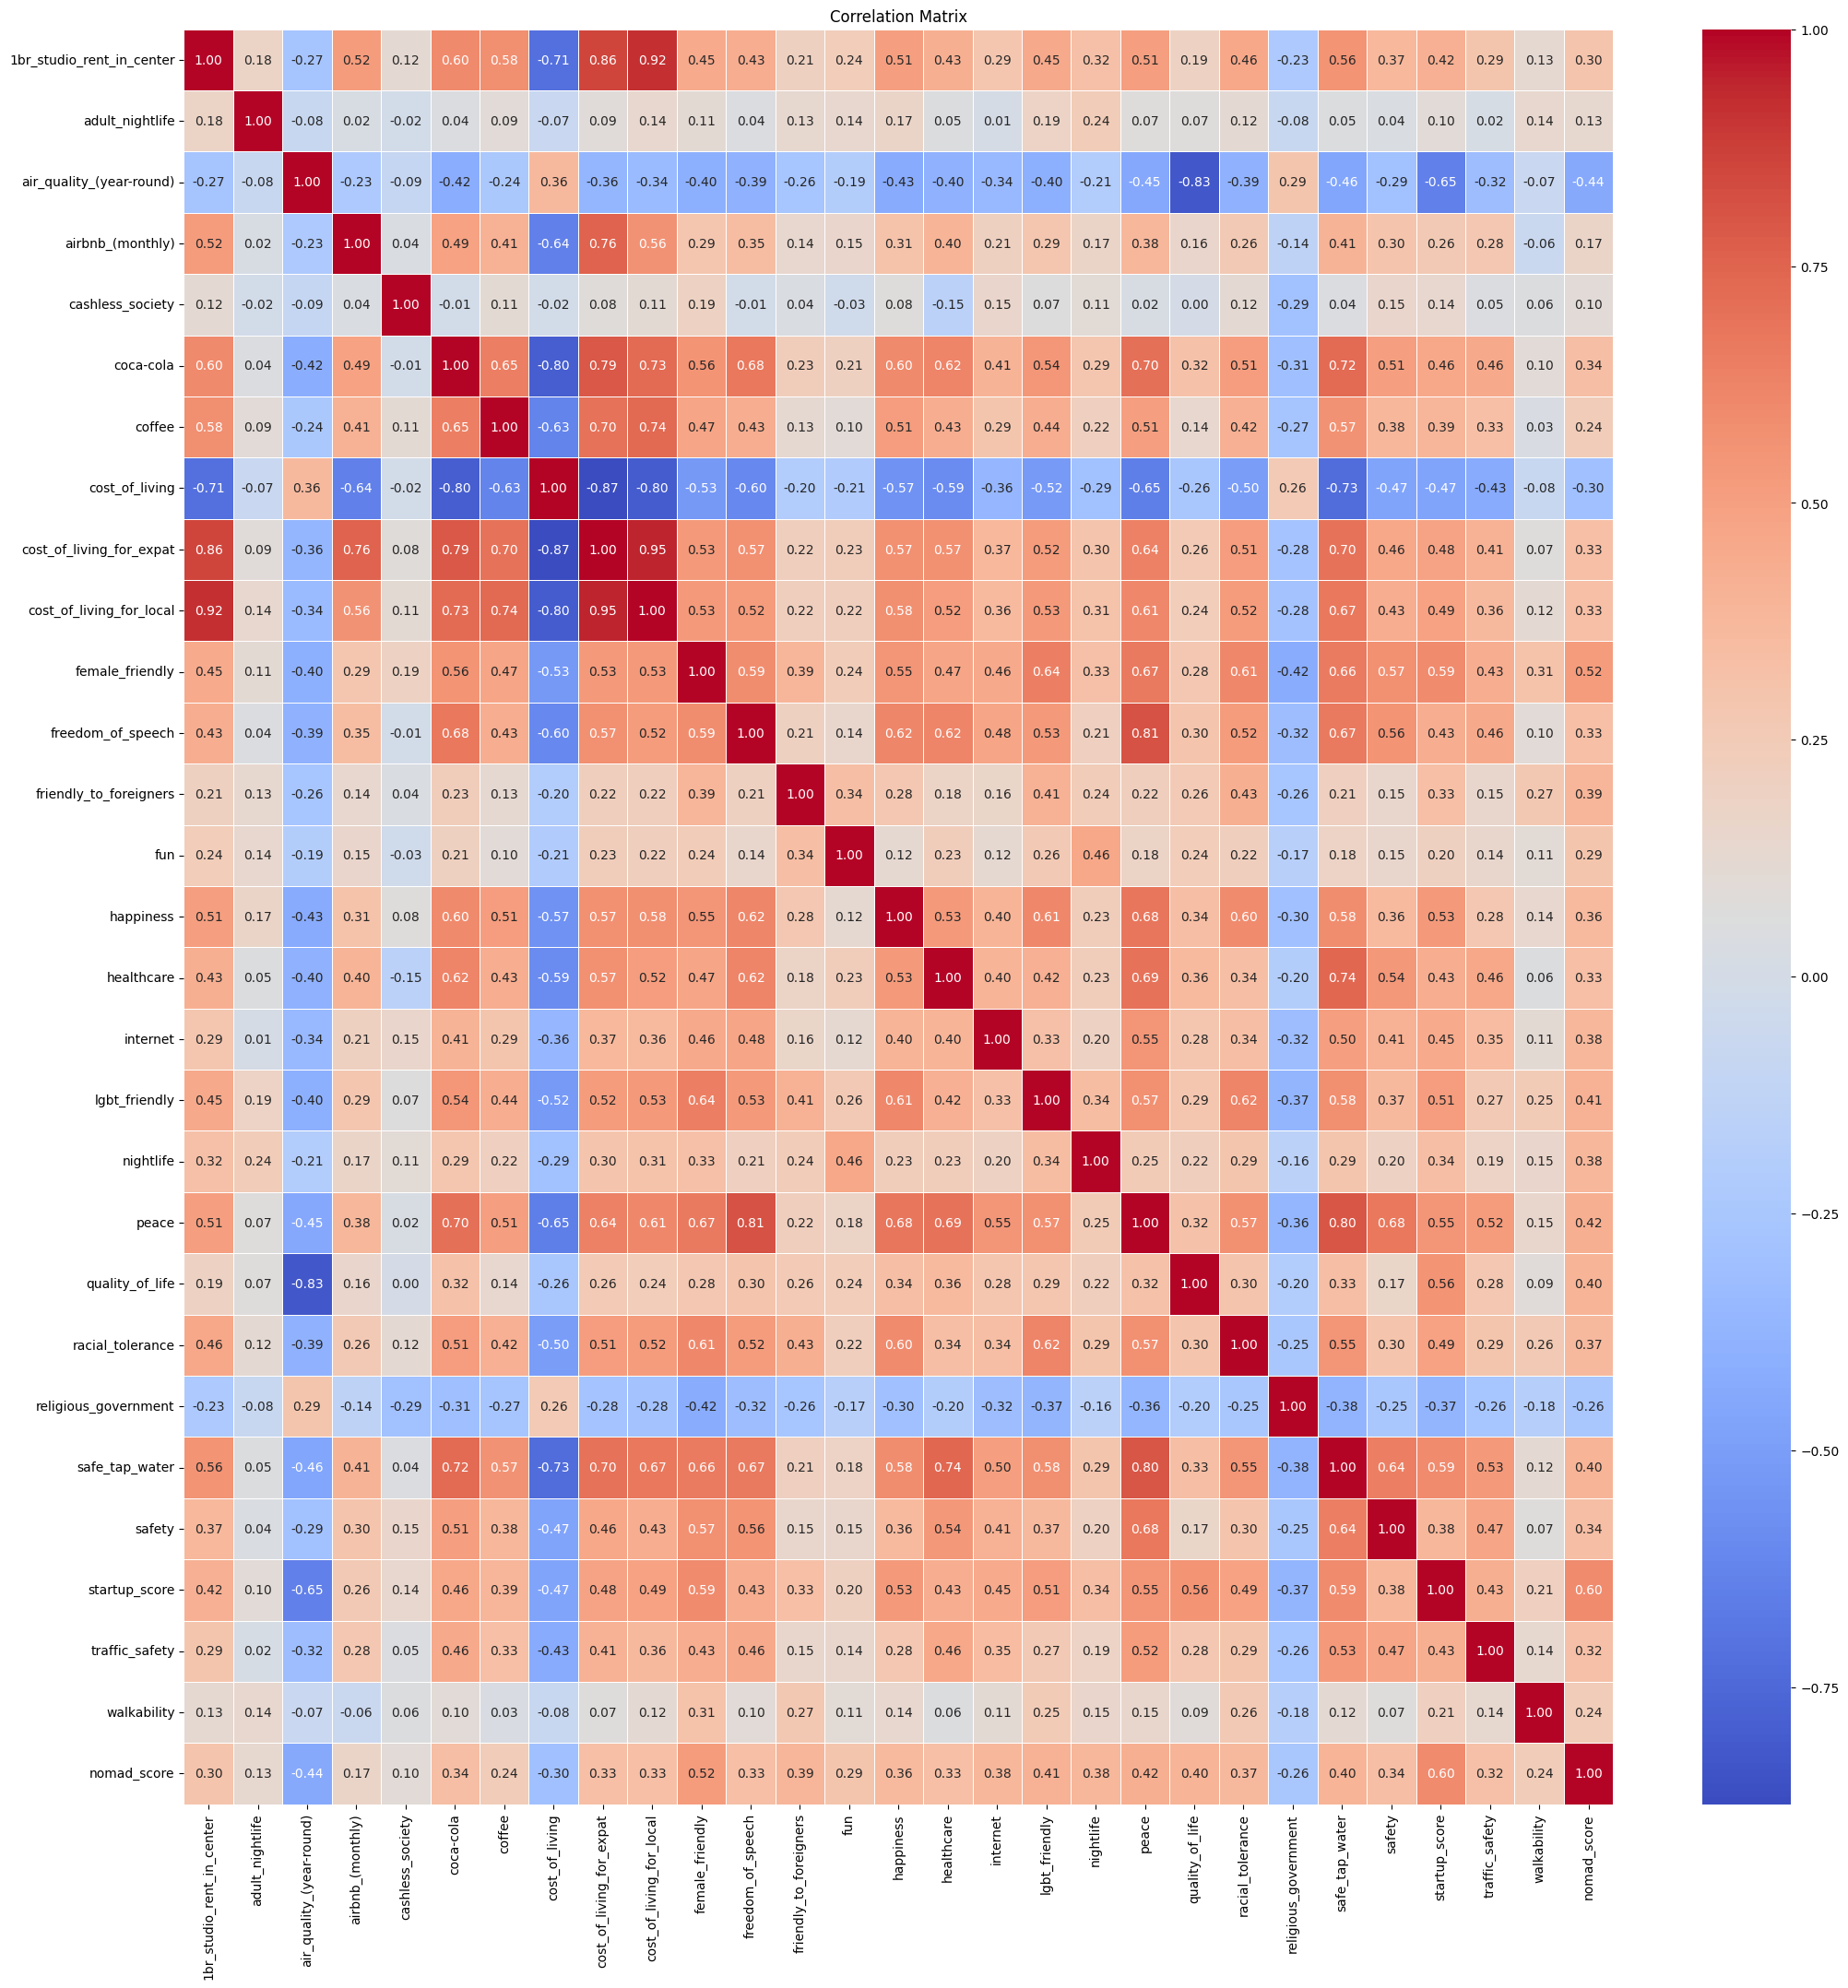

air_quality_(year-round)  cashless_society  cost_of_living  \
0                      42.0           1.00000             3.0   
1                      19.0           1.00000             3.0   
2                      68.0           1.06622             3.0   
3                      23.0           2.00000             3.0   
4                      49.0           3.00000             1.0   

   cost_of_living_for_local  female_friendly  freedom_of_speech  \
0                    -626.0              2.0                1.0   
1                    -349.0              2.0                1.0   
2                    -631.0              1.0                1.0   
3                    -522.0              2.0                1.0   
4                   -2347.0              2.0                1.0   

   friendly_to_foreigners  fun  happiness  healthcare  ...  peace  \
0                     3.0  3.0        3.0         2.0  ...    2.0   
1                     3.0  4.0        3.0         2.0  ...    2.0   
2                     4.0  2.0        2.0         2.0  ...    1.0   
3                     2.0  3.0        1.0         1.0  ...    2.0   
4                     2.0  4.0        2.0         1.0  ...    2.0   

   quality_of_life  racial_tolerance  religious_government  safe_tap_water  \
0              3.0          1.000000                   0.0             0.0   
1              3.0          1.753777                   0.0             0.0   
2              3.0          2.043748                   1.0             0.0   
3              3.0          2.000000                   0.0             0.0   
4              3.0          2.000000                   0.0             0.0   

   safety  startup_score  traffic_safety  walkability  nomad_score  
0     1.0            3.0             4.0          4.0         4.03  
1     2.0            3.0             4.0          4.0         4.51  
2     3.0            2.0             1.0          1.0         4.45  
3     3.0            3.0             3.0          4.0         4.83  
4     3.0            4.0             3.0          4.0         4.11  

[5 rows x 23 columns]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


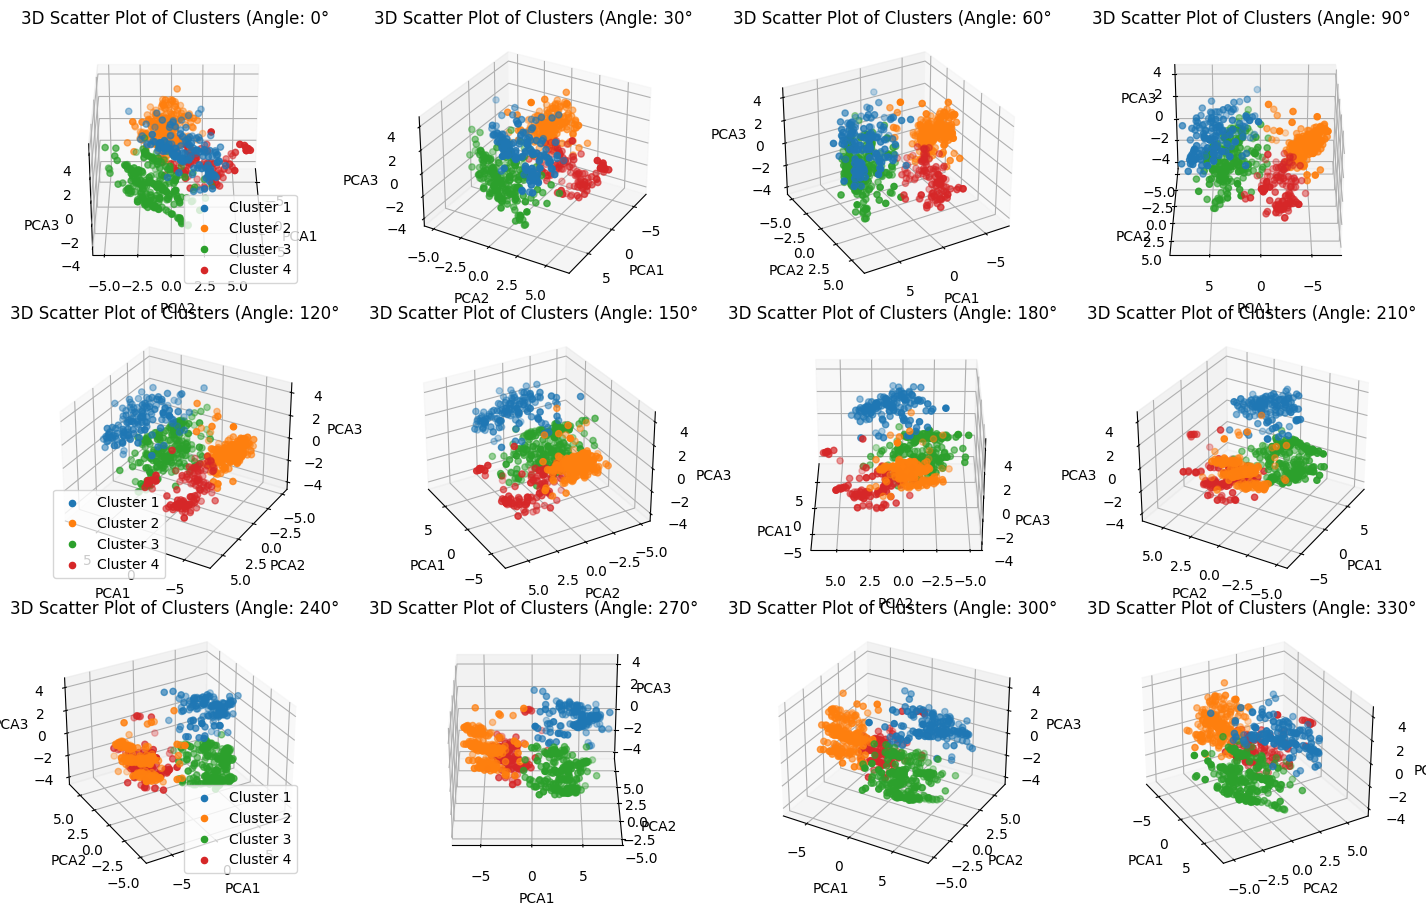

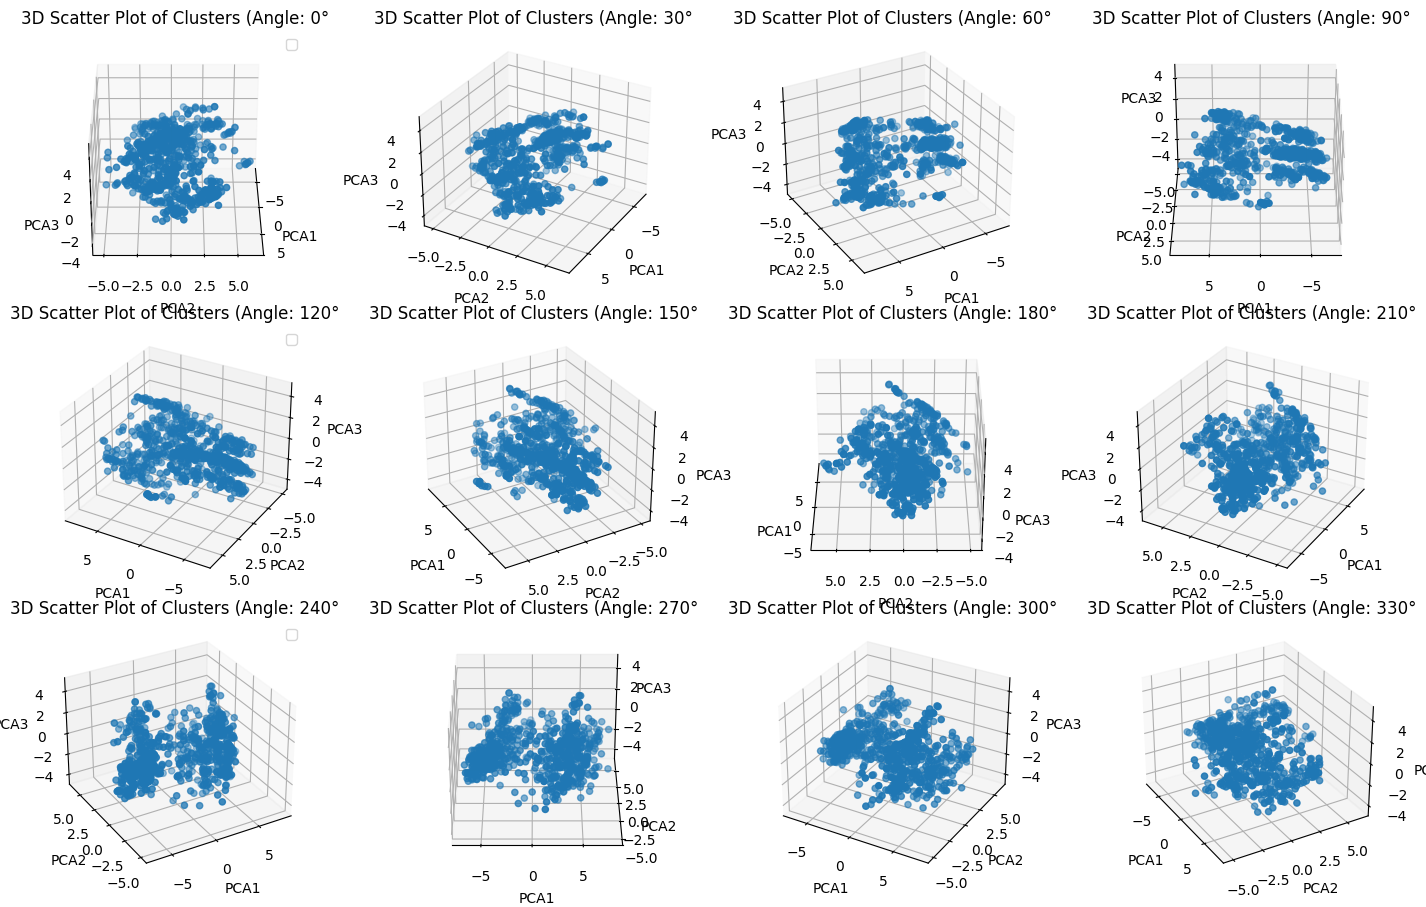

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

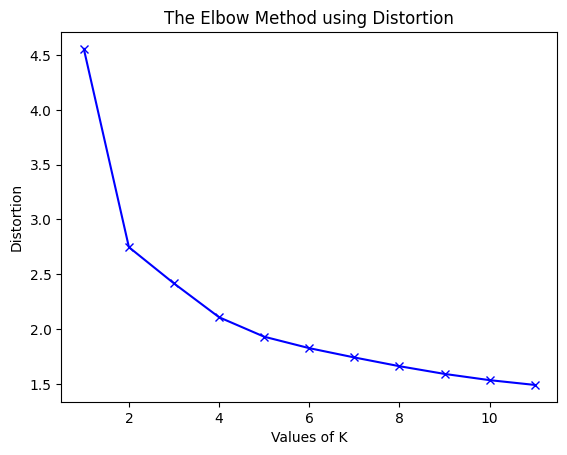

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


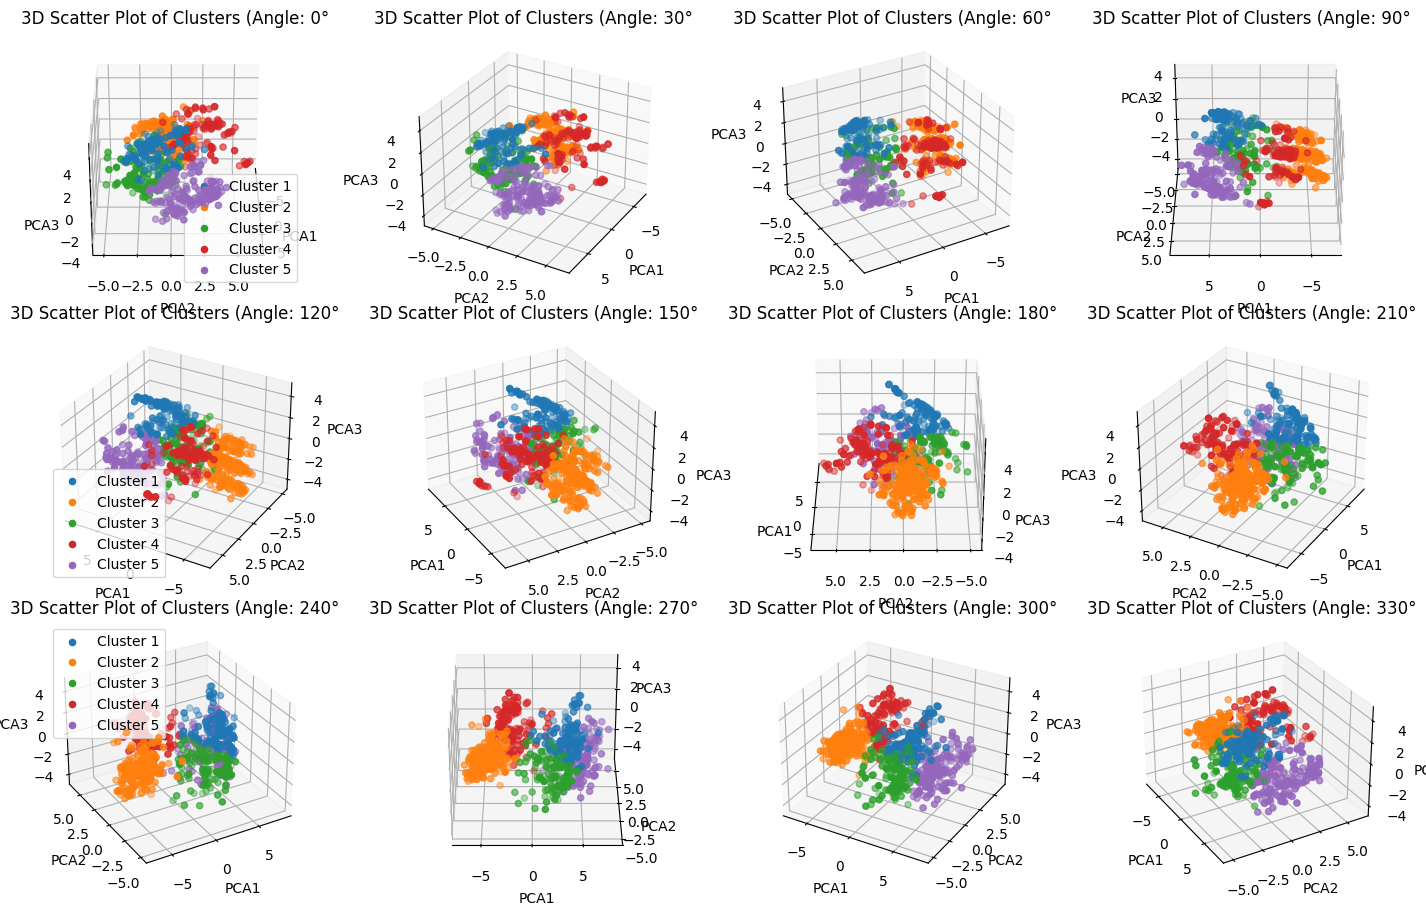

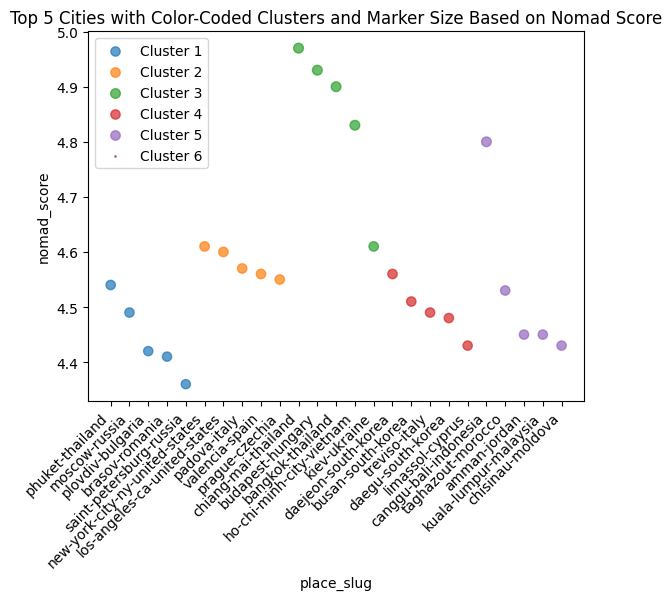

IndexError: ignored

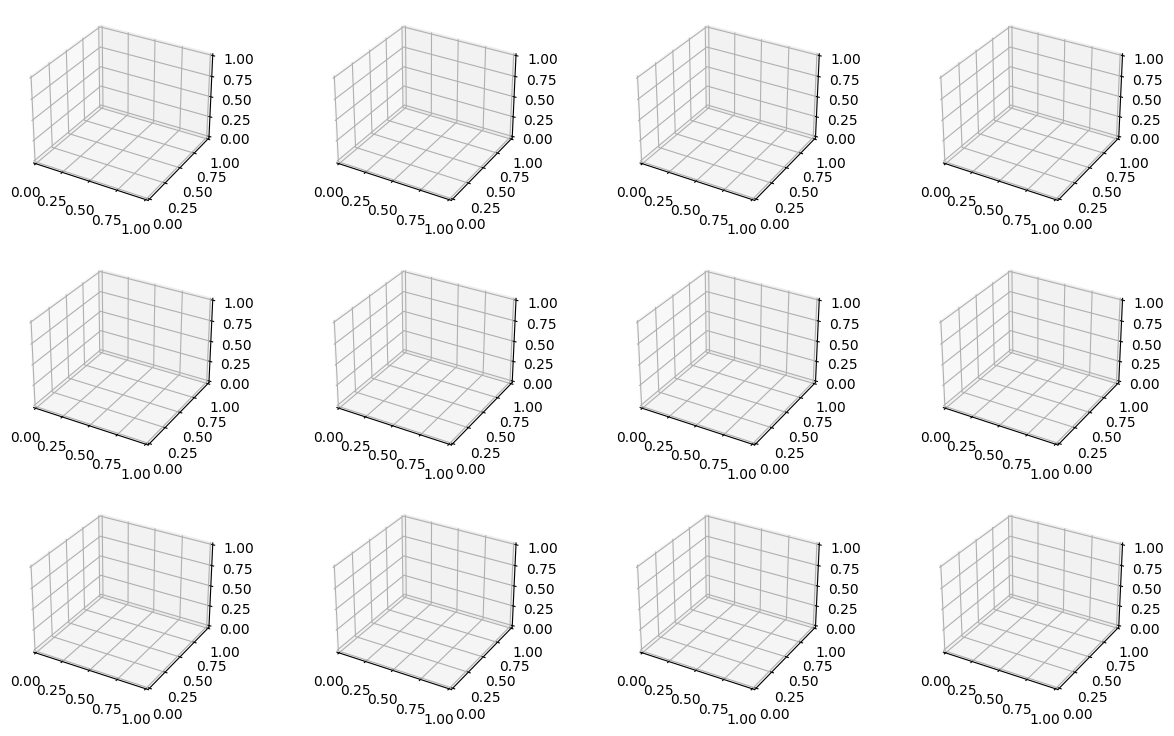

Best Parameters: {'eps': 1.0, 'min_samples': 40}
Best Davies-Bouldin Index: 1.01


Best Parameters: {'n_clusters': 10, 'linkage': 'average', 'metric': 'euclidean'}
Best Davies-Bouldin Index: 0.87


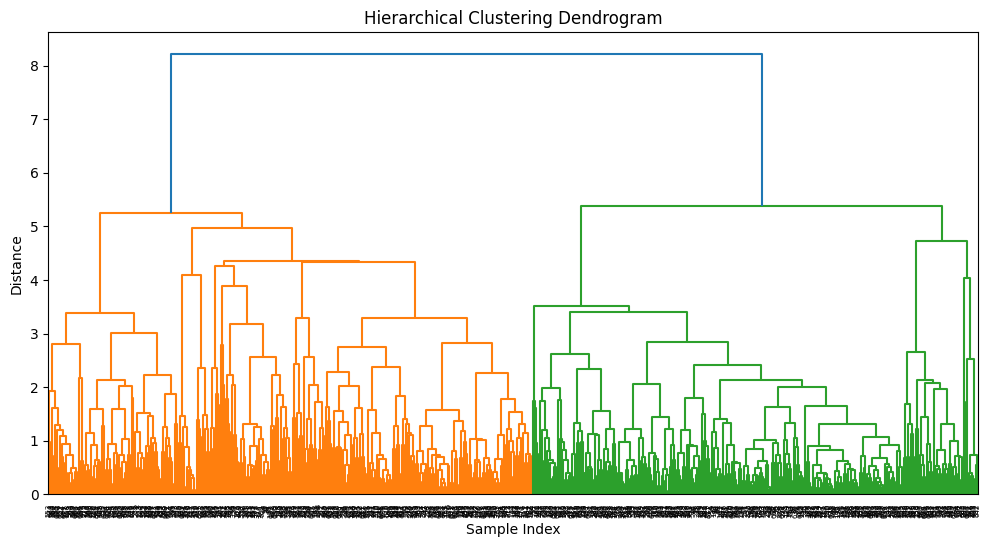

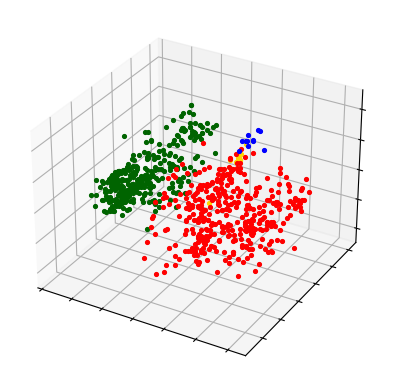

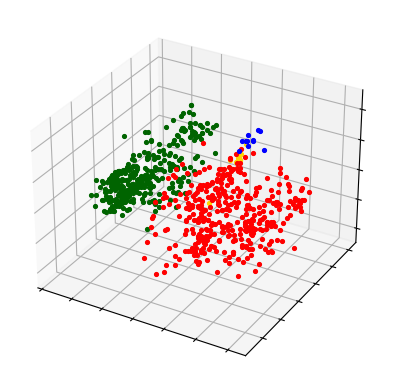

ValueError: ignored